###  Hyperparameter Tuning for the models

In [98]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [99]:
# load the data 
heart_df = pd.read_csv("../data/heart.csv") 
heart_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [100]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [101]:
(heart_df.isnull().sum()).sort_values(ascending=False)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [102]:
X = heart_df.drop(['target'] , axis=1) 
y = heart_df['target']

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 ,stratify=y)

In [104]:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [105]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [106]:
X_trained_scaled = X_train.copy() 
X_test_scaled = X_test.copy() 

X_trained_scaled[num_cols] = scaler.fit_transform(X_train[num_cols]) 
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols]) 



1- Logistic Regrassion with Hyperparameter tuning and GridSearchCV 

In [107]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV , StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.metrics import classification_report , accuracy_score 

In [108]:
# Cross validation strategy 
cv = StratifiedKFold(n_splits=5 ,shuffle=True , random_state=42) 

# logistic regresion with parameter 
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'] ,
    'C' : np.logspace(-3 , 3 , 7) ,
    'solver' : ['saga'] , 
    'l1_ratio' : [0 , 0.25 ,0.5 ,0.75 , 1]
}

lg = LogisticRegression(max_iter=1000)

grid = GridSearchCV(estimator=lg , param_grid=param_grid , cv=cv , scoring="f1" , n_jobs=-1 , error_score="raise") 
grid.fit(X_trained_scaled , y_train) 

cal_lg = CalibratedClassifierCV(grid.best_estimator_ , cv=cv) 
cal_lg.fit(X_trained_scaled , y_train)

y_predict = cal_lg.predict(X_test_scaled) 
print(classification_report(y_test , y_predict))
print(f"{accuracy_score(y_test , y_predict):.2f}")


              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61

0.79


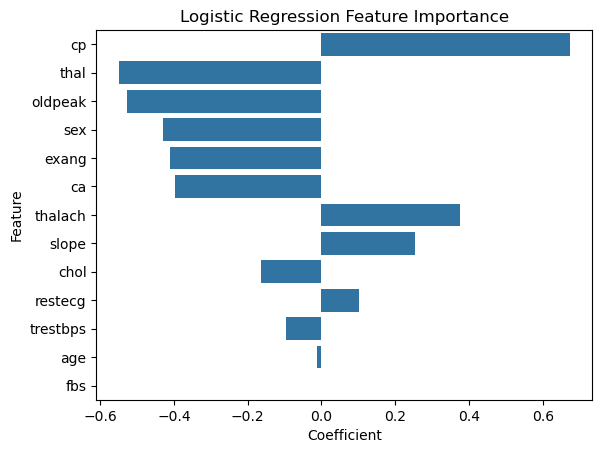

In [109]:
coef = grid.best_estimator_.coef_[0]
features = X_trained_scaled.columns 
importance_df = pd.DataFrame({'Feature' : features , 'Coefficient' : coef}) 
importance_df = importance_df.sort_values(by='Coefficient' , key=abs , ascending=False)

sns.barplot(data=importance_df , x='Coefficient' , y='Feature') 
plt.title("Logistic Regression Feature Importance")
plt.show()

2- Support Vector Machine (SVM)

In [110]:
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline


In [111]:

# Pipeline
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(probability=True, class_weight='balanced'))
])

# Parameter grid
param_grid_svm = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_svm = GridSearchCV(estimator=svc_pipeline, param_grid=param_grid_svm, cv=cv, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Calibrate the best estimator
cal_svm = CalibratedClassifierCV(estimator=grid_svm.best_estimator_, cv=cv)
cal_svm.fit(X_train, y_train)  # 🔴 This line was missing

# Predict
y_predict_svm = cal_svm.predict(X_test)

# Output
print("Best SVM Params:", grid_svm.best_params_)
print(classification_report(y_test, y_predict_svm))
print(f"{accuracy_score(y_test , y_predict_svm):.2f}")



Best SVM Params: {'svm__C': 0.1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61

0.80


3- Random Forest Classifier (RF)


In [112]:
from sklearn.ensemble import RandomForestClassifier 

In [113]:
# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_rf = {
    'n_estimators' : [100 ,200] , 
    'max_depth' : [None , 5 , 10] , 
    'min_samples_split' : [ 2 , 5] , 
    'max_features' : ['sqrt', 'log2'] 
}

rf_model = RandomForestClassifier(class_weight='balanced' , random_state=42) 

grid_rf = GridSearchCV(estimator=rf_model , param_grid=param_grid_rf , scoring='f1' , n_jobs=-1) 
grid_rf.fit(X_train , y_train ) 


cal_rf = CalibratedClassifierCV(estimator=grid_rf.best_estimator_ , cv=cv)
cal_rf.fit(X_train , y_train)

y_predict_rf = cal_rf.predict(X_test) 
print("Best RF Params:", grid_rf.best_params_)
print(classification_report(y_test, y_predict_rf))

Best RF Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



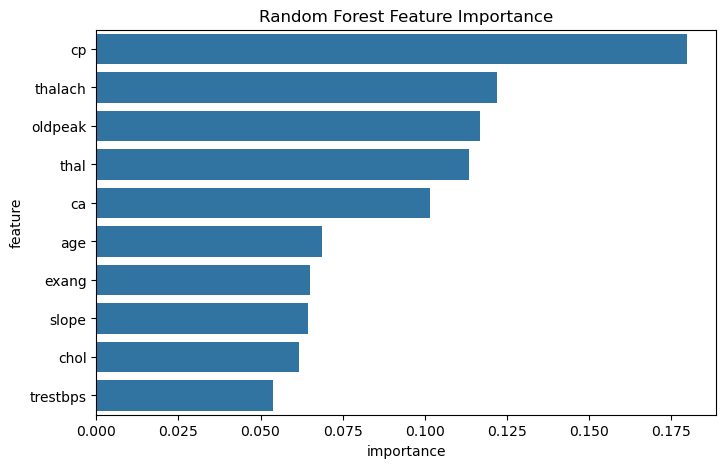

In [114]:
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': cal_rf.estimator.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp.head(10), y='feature', x='importance')
plt.title("Random Forest Feature Importance")
plt.show()


Evaluation of Traditional Machine learning models


In [115]:
models = {
    'Logistic Regression': cal_lg,
    'SVM': cal_svm,
    'Random Forest': cal_rf,
}


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'Best Params': getattr(model, 'best_params_', 'N/A') 
    }

def evaluate_all_models(models: dict, X_test, y_test):
    results = [evaluate_model(name, model, X_test, y_test) for name, model in models.items()]
    df_results = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
    
    print("Model Comparison:\n")
    print(df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])
    
    best_model_row = df_results.iloc[0]
    print(f"\nBest Model: {best_model_row['Model']}")
    
    return df_results

In [96]:
df_results = evaluate_all_models(models, X_test, y_test)

Model Comparison:

                 Model  Accuracy  Precision    Recall  F1-score
1        Random Forest  0.819672   0.761905  0.969697  0.853333
0                  SVM  0.803279   0.756098  0.939394  0.837838
2  Logistic Regression  0.491803   1.000000  0.060606  0.114286

Best Model: Random Forest


<Figure size 640x480 with 0 Axes>

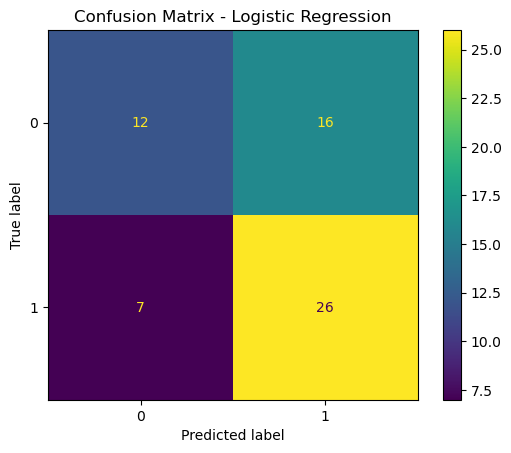

<Figure size 640x480 with 0 Axes>

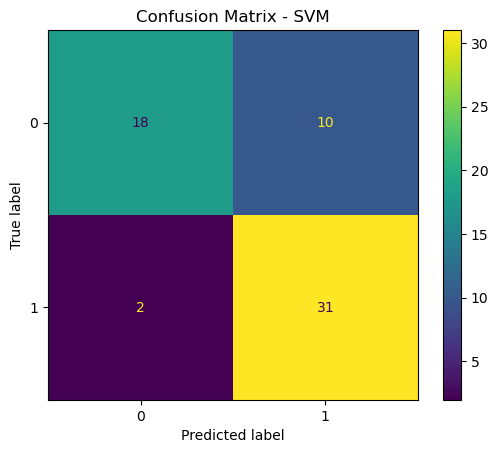

<Figure size 640x480 with 0 Axes>

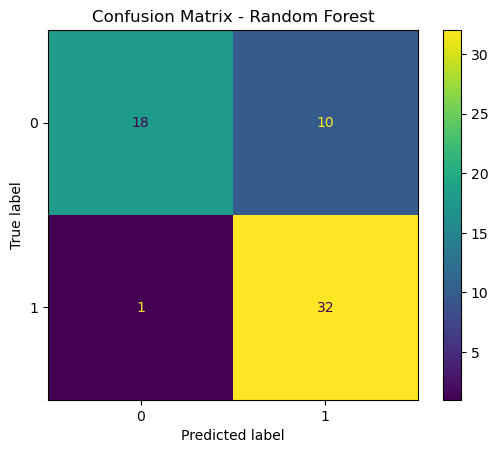

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    plt.figure()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

In [119]:
# Save the final model
import joblib
joblib.dump(cal_rf, '../models/final_model.pkl')

['../models/final_model.pkl']

In [120]:
# Save classification_report as Text 

report = classification_report(y_test, y_predict_rf)
# Save the report to a text file
with open('../results/evaluation_report.txt', 'w') as f:
    f.write("Best Random Forest Params: " + str(grid_rf.best_params_) + "\n\n")
    f.write(report)